<h2>Import Libraries:</h2>

In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from pandas.api.types import is_string_dtype

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'

<h2>Verileri Çıkarın:</h2>

In [2]:
#Verileri bir veri çerçevesine aktar
data = pd.read_csv('../input/melbourne-housing-market/Melbourne_housing_FULL.csv') 

#X için sütunları seç
cols = data.columns
cols = cols.drop('Price')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [3]:
#Satış Fiyatı tanımlanmayan veri örneklerini aşağıya bırakın
data = data[data.Price.notnull()]

#Verinin ilk beş örneğini görüntüle
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


<h2>Veri Araştırma, Temizleme ve Dönüştürme:</h2>

In [4]:
#Kategorik verileri sayısal verilerden ayırın
categorical = data.select_dtypes(exclude = [np.number])
numerical = data.select_dtypes(include = [np.number])

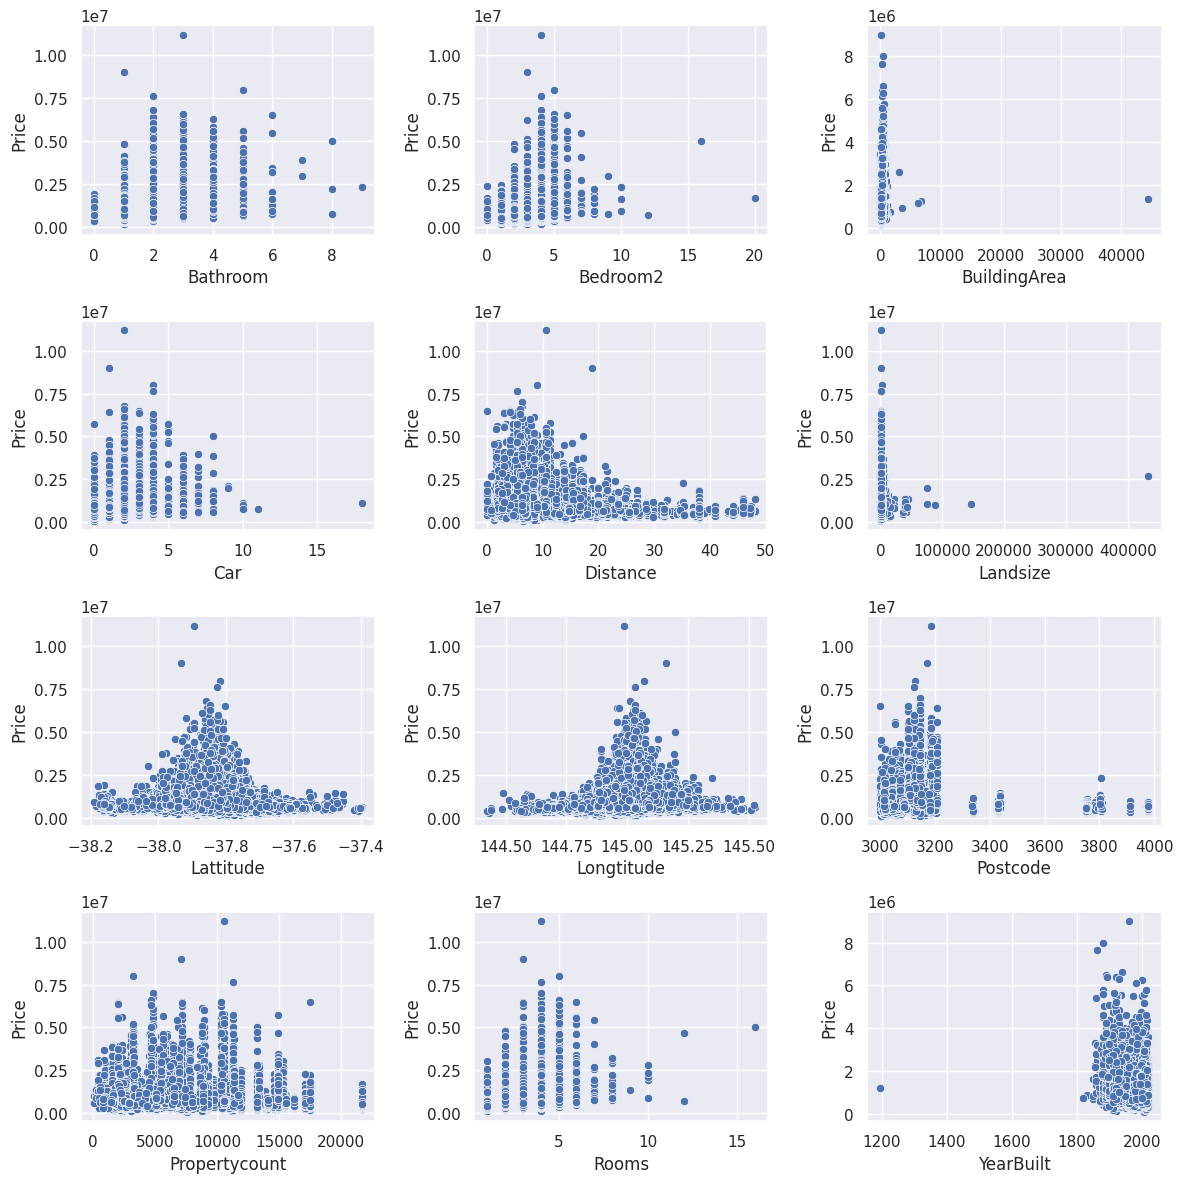

In [5]:
%config InlineBackend.figure_format = 'png'

#Sayısal verilerin Satış Fiyatına göre grafiğini çıkarın
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for idx, feat in enumerate(numerical.columns.difference(['Price'])):
    ax = axes[int(idx / 3), idx%3]
    sns.scatterplot(x=feat, y='Price', data=numerical, ax=ax);
    ax.set_xlabel(feat)
    ax.set_ylabel('Price')
    
fig.tight_layout();

In [6]:
#İndirimli Fiyatın özelliklerini tanımlayın
data['Price'].describe()

count    2.724700e+04
mean     1.050173e+06
std      6.414671e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.700000e+05
75%      1.295000e+06
max      1.120000e+07
Name: Price, dtype: float64

<Axes: xlabel='Price', ylabel='Density'>

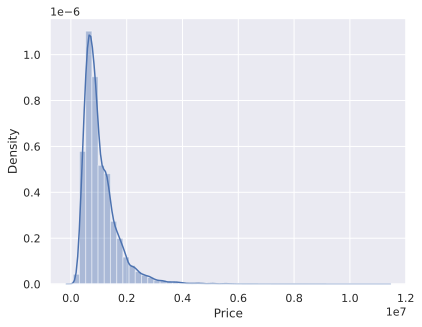

In [7]:
%config InlineBackend.figure_format = 'svg'
#Her örneğin SalePrice'ını çizin
sns.distplot(data['Price'])

In [8]:
#çarpıklık ve basıklık
print("Skewness: %f" % data['Price'].skew())
print("Kurtosis: %f" % data['Price'].kurt())

Skewness: 2.588969
Kurtosis: 13.097201


In [9]:
#Eğitim amacıyla kategorik verileri sayısal verilere dönüştürülür
for col, col_data in data.items():
    if is_string_dtype(col_data):
        data[col] = data[col].astype('category').cat.as_ordered().cat.codes

In [10]:
'''SatışFiyat korelasyon matrisi
corrmat = data.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);'''

"SatışFiyat korelasyon matrisi\ncorrmat = data.corr()\nf, ax = plt.subplots(figsize=(8, 6))\nsns.set(font_scale=0.5)\nsns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);"

<ul>
    <li><b>{ ' Rooms ', ' Bedroom2 ', ' Bathroom ', ' Car ' }</b> <b>pozitif korelasyonlu</b>
    <li><b>{ ' Type ', ' Distance ', ' YearBuilt ' }</b> <b>negatif korolasyonlu</b>
</ul>

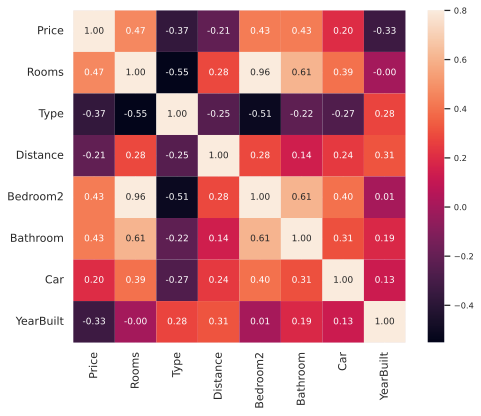

In [11]:
crcols = ['Price', 'Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt']
corrmat = data[crcols].corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.75)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);

<ul>
    <li><b>Bedroom2</b> ve <b>Room</b> birbirleriyle güçlü bir şekilde ilişkilidir. Bu nedenle, Bedroom2'yi analizden çıkarmak akıllıca bir seçim olacaktır.
</ul>

In [12]:
#Öznitelik Seçimi
crcols.remove('Bedroom2')
cols = crcols
data = data[cols]
data.head()

,Price,Rooms,Type,Distance,Bathroom,Car,YearBuilt
1,1480000.0,2,0,2.5,1.0,1.0,NaN
2,1035000.0,2,0,2.5,1.0,0.0,1900.0
4,1465000.0,3,0,2.5,2.0,0.0,1900.0
5,850000.0,3,0,2.5,2.0,1.0,NaN
6,1600000.0,4,0,2.5,1.0,2.0,2014.0


In [13]:
#Basit Imputer'ı kullanarak boş veri hücrelerini doldurulur
y = data.Price
X = SimpleImputer().fit_transform(data[cols])

In [14]:
#Verileri, eğitim ve doğrulama veri kümelerine bölün
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3)

#Verileri PCA algoritmasına beslemeden önce standartlaştırın
scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)

#Eğitimi hızlandırmak amacıyla özellik sayısını azaltmak için PCA algoritmasını kullanın
pca = PCA(.95)
pca.fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

<h2>Eğitim Modeli:</h2>

In [15]:
#XGBRegressor kullanarak bir modeli eğitme
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, nthread=10)
model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, nthread=10, num_parallel_tree=None,
             predictor=None, ...)

<h2>Cross Validate: </h2>

In [16]:
#Doğrulama veri kümesini kullanarak eğitilen modeli doğrulayın
cvt = cross_val_score(model, X, y)

mae = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error')

print("Model Accuracy:\t",cvt.mean())
print("\nMean Absolute Error:\t",(-1 * mae.mean()))

Model Accuracy:	 0.9994412748290069

Mean Absolute Error:	 458.7033955158214


In [17]:
#Çapraz doğrulama kümesindeki evler için Satış Fiyatını Tahmin Et
predict_y = model.predict(val_X)

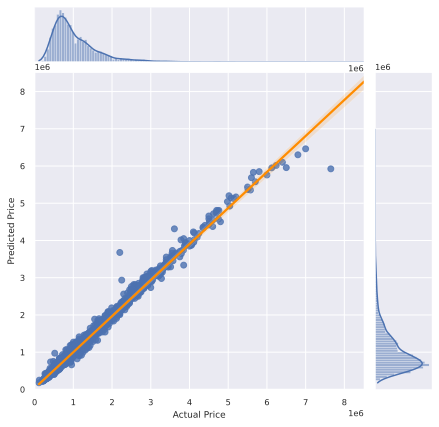

In [18]:
#Gerçek Fiyat değerini tahmin edilen Satış Fiyatına göre çizin
g = sns.jointplot(x= val_y, y= predict_y, kind='reg', xlim=(0,8500000), ylim=(0,8500000),
                  joint_kws={'line_kws':{'color':'darkorange'}})
g.set_axis_labels(xlabel='Actual Price', ylabel='Predicted Price')